Let's train this model on TPU. It's worth it.

## Imports

In [1]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.6.0


## TPU detection

In [ ]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
print("Number of accelerators: ", strategy.num_replicas_in_sync)

## Configuration

In [3]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

if tpu:
  BATCH_SIZE = 16*strategy.num_replicas_in_sync  # A TPU has 8 cores so this will be 128
else:
  BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 128, there will be 23 batches per training epoch and 5 batch(es) per validation run.


In [4]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  # In eager mode, iterate in the Datset directly.
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [5]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
  return dataset

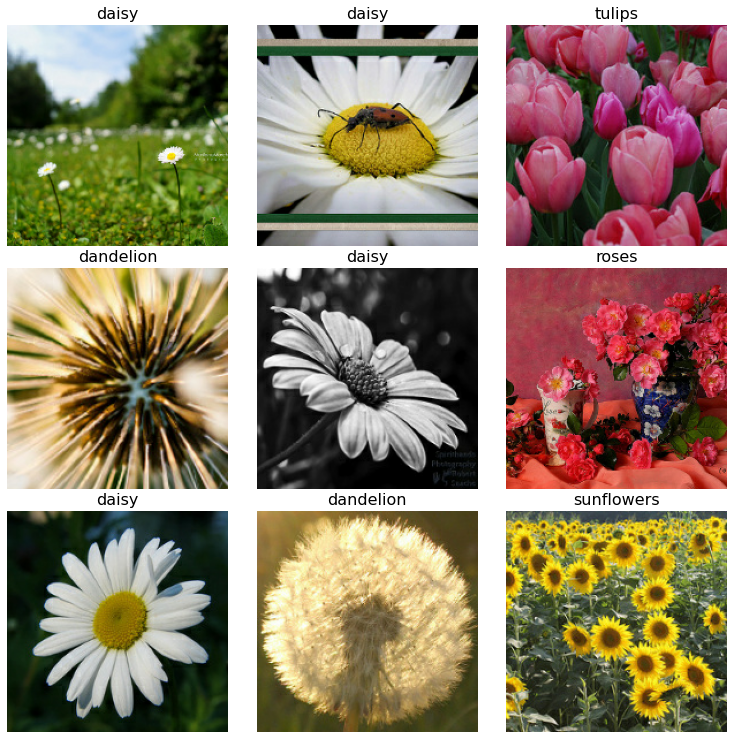

In [6]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [7]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 160)

## Model [WORK WAS REQUIRED HERE]

In [8]:
with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)

  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=[*IMAGE_SIZE, 3]),
      tf.keras.layers.Conv2D(kernel_size=3, filters=30, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=60, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=90, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=110, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=130, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=40, padding='same', activation='relu'),
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 30)      4350      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 60)        16260     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 90)        48690     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 90)        0

## Training

In [9]:
EPOCHS = 20

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/20
23/23 [==============================] - 19s 409ms/step - loss: 1.5524 - accuracy: 0.2846 - val_loss: 1.4710 - val_accuracy: 0.3000
Epoch 2/20
23/23 [==============================] - 2s 110ms/step - loss: 1.3200 - accuracy: 0.4018 - val_loss: 1.2581 - val_accuracy: 0.4406
Epoch 3/20
23/23 [==============================] - 2s 109ms/step - loss: 1.2236 - accuracy: 0.4701 - val_loss: 1.2292 - val_accuracy: 0.5116
Epoch 4/20
23/23 [==============================] - 3s 111ms/step - loss: 1.1690 - accuracy: 0.5020 - val_loss: 1.1699 - val_accuracy: 0.5232
Epoch 5/20
23/23 [==============================] - 3s 122ms/step - loss: 1.1254 - accuracy: 0.5319 - val_loss: 1.1198 - val_accuracy: 0.5710
Epoch 6/20
23/23 [==============================] - 3s 117ms/step - loss: 1.0853 - accuracy: 0.5645 - val_loss: 1.0782 - val_accuracy: 0.5797
Epoch 7/20
23/23 [==============================] - 2s 110ms/step - loss: 1.0287 - accuracy: 0.5876 - val_loss: 1.0115 - val_accuracy: 0.5971
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


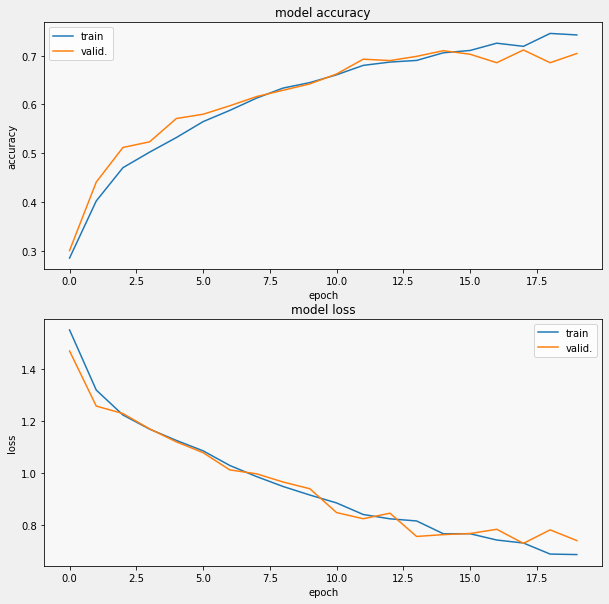

In [10]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [21]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(160)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

10/10 [==============================] - 1s 13ms/step - loss: 0.6715 - accuracy: 0.7312
['roses', 'sunflowers', 'tulips', 'roses', 'dandelion', 'dandelion', 'sunflowers', 'tulips', 'dandelion', 'dandelion', 'tulips', 'dandelion', 'dandelion', 'dandelion', 'sunflowers', 'daisy', 'tulips', 'dandelion', 'tulips', 'sunflowers', 'tulips', 'roses', 'daisy', 'dandelion', 'roses', 'dandelion', 'dandelion', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'daisy', 'roses', 'tulips', 'roses', 'roses', 'dandelion', 'daisy', 'tulips', 'tulips', 'sunflowers', 'daisy', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'sunflowers', 'sunflowers', 'sunflowers', 'tulips', 'sunflowers', 'dandelion', 'daisy', 'roses', 'sunflowers', 'roses', 'dandelion', 'daisy', 'tulips', 'tulips', 'dandelion', 'tulips', 'sunflowers', 'tulips', 'tulips', 'tulips', 'dandelion', 'tulips', 'dandelion', 'dandelion', 'dandelion', 'roses', 'dandelion', 'roses', 'dandelion', 'dandelion', 'sunflowers', 'daisy', 'dandelion', 

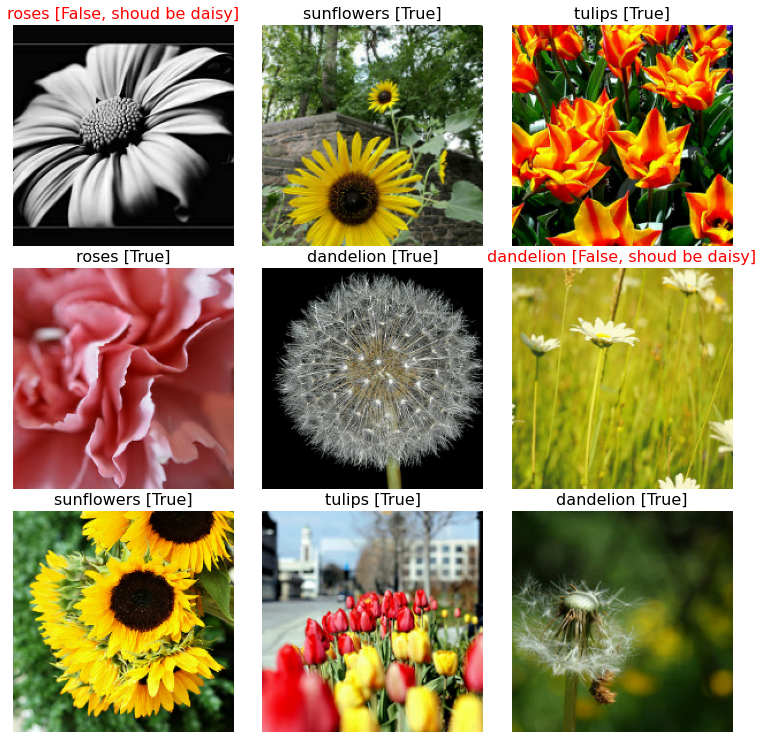

In [22]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
